<a href="https://colab.research.google.com/github/faisalaqureshi/power-forecasting/blob/main/NLP_Energy_Market.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Predicting Demand Trade Size (price * quanitity) for power in PJM - Sep 2022

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import TimeSeriesSplit
import seaborn as sns
import datetime as dt
import matplotlib.pyplot as plt

## Data Cleaning

### PJM dataset cleaning

In [3]:
# importing the raw dataset from PJM's historical day head website
# Demand (bids) for month of September 2022

# deleting the UTC datetime column as we already have EPT
# converting the column to datetime format for easier analysis later
pjm_day_ahead_raw = pd.read_csv("hrl_da_demand_bids.csv", parse_dates=["datetime_beginning_ept"]).drop("datetime_beginning_utc", axis = 1)
pjm_day_ahead_raw.head()

,datetime_beginning_ept,price_point,mw
0,2022-09-30 23:00:00,0.0,68093.7
1,2022-09-30 23:00:00,34.0,0.1
2,2022-09-30 23:00:00,45.0,0.1
3,2022-09-30 23:00:00,48.0,0.1
4,2022-09-30 23:00:00,50.0,7.0


In [4]:
#rename the columns so they are easier to read
pjm_day_ahead = pjm_day_ahead_raw.rename({"datetime_beginning_ept":"date_time", "price_point":"price"}, axis=1)
pjm_day_ahead.head()

,date_time,price,mw
0,2022-09-30 23:00:00,0.0,68093.7
1,2022-09-30 23:00:00,34.0,0.1
2,2022-09-30 23:00:00,45.0,0.1
3,2022-09-30 23:00:00,48.0,0.1
4,2022-09-30 23:00:00,50.0,7.0


In [5]:
# indexing by datetime
pjm_day_ahead.index = pjm_day_ahead["date_time"]

# grouping by month and aggregating data for long-term forecasting
# using mean instead of median so outliers can be captured

pjm_day_ahead_grouped = pjm_day_ahead.groupby(pd.Grouper(freq='H')).agg(np.mean)

<ipython-input-5-a5b1823ed636>:7: FutureWarning: The operation <function mean at 0x7fe944197280> failed on a column. If any error is raised, this will raise an exception in a future version of pandas. Drop these columns to avoid this warning.
  pjm_day_ahead_grouped = pjm_day_ahead.groupby(pd.Grouper(freq='H')).agg(np.mean)


In [6]:
# creating a new variable for trade size, where we multiply price by quantity to 
# get trade size at every hour in September 2022
pjm_day_ahead_grouped["tradesize"] = pjm_day_ahead_grouped["price"] * pjm_day_ahead_grouped["mw"]
pjm_day_ahead_ts = pjm_day_ahead_grouped.copy()

### Weather dataset cleaning

In [7]:
norristown = pd.read_csv("norristown_pa.csv", parse_dates=["datetime"])
norristown.head()

,name,datetime,temp,feelslike,dew,humidity,precip,precipprob,preciptype,snow,...,sealevelpressure,cloudcover,visibility,solarradiation,solarenergy,uvindex,severerisk,conditions,icon,stations
0,norristown pa,2022-09-01 00:00:00,65.0,65.0,55.7,71.98,0.0,0,NaN,0,...,1012.9,0.0,9.9,0,NaN,0,10,Clear,clear-night,"72510954782,72030464752,KPHL,KPTW,KLOM"
1,norristown pa,2022-09-01 01:00:00,64.9,64.9,55.7,72.10,0.0,0,NaN,0,...,1013.2,0.0,9.9,0,NaN,0,10,Clear,clear-night,"72510954782,72030464752,KPHL,KPTW,KLOM"
2,norristown pa,2022-09-01 02:00:00,66.1,66.1,55.3,68.36,0.0,0,NaN,0,...,1013.2,0.0,9.9,0,NaN,0,10,Clear,clear-night,"72510954782,72030464752,KPHL,KPTW,KLOM"
3,norristown pa,2022-09-01 03:00:00,64.8,64.8,55.9,73.00,0.0,0,NaN,0,...,1013.2,0.0,9.9,0,NaN,0,10,Clear,clear-night,"72510954782,72030464752,KPHL,KPTW,KLOM"
4,norristown pa,2022-09-01 04:00:00,60.7,60.7,56.8,86.98,0.0,0,NaN,0,...,1013.3,0.0,9.9,0,NaN,0,10,Clear,clear-night,"72510954782,72030464752,KPHL,KPTW,KLOM"


In [8]:
# only considering humidity for simplicity, could use many if it is necessary
norristown_pa = norristown.copy()

# merging the two datasets
pjm_hum = pjm_day_ahead_ts.merge(norristown_pa, left_on="date_time", right_on="datetime", how="inner")
pjm_hum.head()

,price,mw,tradesize,name,datetime,temp,feelslike,dew,humidity,precip,...,sealevelpressure,cloudcover,visibility,solarradiation,solarenergy,uvindex,severerisk,conditions,icon,stations
0,150.666667,5324.586667,802237.724444,norristown pa,2022-09-01 00:00:00,65.0,65.0,55.7,71.98,0.0,...,1012.9,0.0,9.9,0,NaN,0,10,Clear,clear-night,"72510954782,72030464752,KPHL,KPTW,KLOM"
1,150.666667,5029.620000,757796.080000,norristown pa,2022-09-01 01:00:00,64.9,64.9,55.7,72.10,0.0,...,1013.2,0.0,9.9,0,NaN,0,10,Clear,clear-night,"72510954782,72030464752,KPHL,KPTW,KLOM"
2,150.666667,4833.826667,728296.551111,norristown pa,2022-09-01 02:00:00,66.1,66.1,55.3,68.36,0.0,...,1013.2,0.0,9.9,0,NaN,0,10,Clear,clear-night,"72510954782,72030464752,KPHL,KPTW,KLOM"
3,150.666667,4726.766667,712166.177778,norristown pa,2022-09-01 03:00:00,64.8,64.8,55.9,73.00,0.0,...,1013.2,0.0,9.9,0,NaN,0,10,Clear,clear-night,"72510954782,72030464752,KPHL,KPTW,KLOM"
4,150.666667,4738.480000,713930.986667,norristown pa,2022-09-01 04:00:00,60.7,60.7,56.8,86.98,0.0,...,1013.3,0.0,9.9,0,NaN,0,10,Clear,clear-night,"72510954782,72030464752,KPHL,KPTW,KLOM"


In [9]:
# setting a new index to datetime
pjm_hum.index = pjm_hum["datetime"]
pjm_hum = pjm_hum.drop(["datetime", "stations", "icon", "conditions", "name", "price", "mw", "preciptype", "solarenergy"], axis = 1)
pjm_hum.head()

,tradesize,temp,feelslike,dew,humidity,precip,precipprob,snow,snowdepth,windgust,windspeed,winddir,sealevelpressure,cloudcover,visibility,solarradiation,uvindex,severerisk
datetime,,,,,,,,,,,,,,,,,,
2022-09-01 00:00:00,802237.724444,65.0,65.0,55.7,71.98,0.0,0,0,0,6.3,3.3,255,1012.9,0.0,9.9,0,0,10
2022-09-01 01:00:00,757796.080000,64.9,64.9,55.7,72.10,0.0,0,0,0,6.9,3.2,268,1013.2,0.0,9.9,0,0,10
2022-09-01 02:00:00,728296.551111,66.1,66.1,55.3,68.36,0.0,0,0,0,9.6,3.9,254,1013.2,0.0,9.9,0,0,10
2022-09-01 03:00:00,712166.177778,64.8,64.8,55.9,73.00,0.0,0,0,0,8.7,3.3,259,1013.2,0.0,9.9,0,0,10
2022-09-01 04:00:00,713930.986667,60.7,60.7,56.8,86.98,0.0,0,0,0,4.9,1.7,249,1013.3,0.0,9.9,0,0,10


In [10]:
# splitting train and test set for time series
tss = TimeSeriesSplit(n_splits = 3)

X = pjm_hum.loc[:, pjm_hum.columns != "tradesize"]
y = pjm_hum["tradesize"]

for train_index, test_index in tss.split(X):
    X_train, X_test = X.iloc[train_index, :], X.iloc[test_index,:]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]


## WIP: Exploratory Data Analysis

<Axes: xlabel='datetime', ylabel='tradesize'>

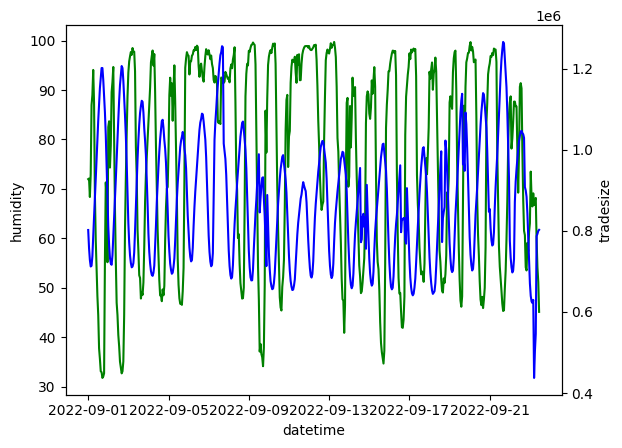

In [11]:
# plotting humidity against tradesizes
sns.lineplot(data=X_train.humidity, color="g")
ax2 = plt.twinx()
sns.lineplot(data=y_train, color="b", ax=ax2)

Not as much of a trend as we'd hope, but it's likely that more variables aid to prediction than not!

## WIP: Testing Different Regression variables!

In [12]:
# premilinary regression
regr = GradientBoostingRegressor(random_state=42)
regr.fit(X_train, y_train)
predictions = regr.predict(X_test)
print(regr.score(X_test, y_test))

-1.7155845184748375


In [13]:
# cleaning predictions dataset to compare values
combined = {"datetime":y_test.index, "preds":predictions}
combined_df = pd.DataFrame(data=combined)
combined_df.index = pd.to_datetime(combined_df["datetime"])
ts_preds = combined_df.copy().drop("datetime", axis = 1)
ts_preds

,preds
datetime,
2022-09-23 12:00:00,889173.093590
2022-09-23 13:00:00,878899.652905
2022-09-23 14:00:00,907252.786810
2022-09-23 15:00:00,916076.175023
2022-09-23 16:00:00,913643.743627
...,...
2022-09-30 19:00:00,814610.815729
2022-09-30 20:00:00,741275.404427
2022-09-30 21:00:00,740905.879339


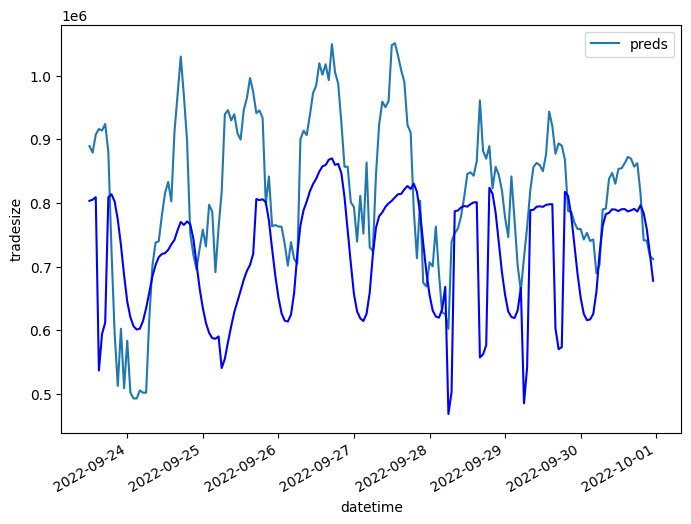

In [14]:
#Plotting the trade sizes 
fig, ax = plt.subplots(figsize=(8, 6))
sns.lineplot(data=ts_preds, color="g", sort=False)
sns.lineplot(data=y_test, color="b", ax=ax, sort=False)
fig.autofmt_xdate()

Doesn't look too great!